In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.display import clear_output
from collections import deque
import matplotlib.pyplot as plt
import random
from gi.repository import Notify

Notify.init ("Bingo")

In [ ]:
%matplotlib notebook
train_notif = Notify.Notification.new ("Bingo","AI Training....")
train_comp_notif = Notify.Notification.new ("Bingo","AI Training Complete")

In [56]:
class bingo_agent:
    def __init__(self,state_size,action_size,epsilon,epsilon_decay,deque_len,gamma,learning_rate,y1,y2,act1,act2,opti,loss):
        self.state_size = state_size
        self.action_size = action_size
        self.Epsilon = epsilon
        self.Gamma = gamma
        self.Epsilon_decay = epsilon_decay
        self.Epsilon_min = 0.5
        self.batch_size = 20
        self.memory = deque(maxlen = deque_len)
        self.model = self.buildModel(learning_rate,y1,y2,act1,act2,opti,loss)
        self.grid = np.random.choice(range(1,26),25,replace = False)
        
    def create_grid(self):
        self.grid = np.random.choice(range(1,26),25,replace = False)   
    
    def show_grid(self,state):
        temp_grid = np.copy(self.grid)
        temp_grid[[i for i in range(25) if state[0,i] == 1]] = 0
        sq_grid = np.reshape(temp_grid,[5,5])
        print (sq_grid)
        
    def perform_move(self,state,action):
        new_state = np.copy(state)
        new_state[0,action] = 1
        lines = self.find_done(new_state)
        if (lines >= 5):
            done = True
            reward = 10
        else:
            done = False
            reward = 0
        value = self.grid[action]
        return new_state,reward,done,value
    
    def convert_action(self,value):
        return np.where (self.grid == value)[0][0]
    
    def buildModel(self,learning_rate,y1,y2,act1,act2,opti,loss):
        model = Sequential()
        model.add(Dense(y1,input_dim = self.state_size,activation = act1))
        if (y2 != 0):
            model.add(Dense(y2,activation = act2))
        model.add(Dense(self.action_size,activation = 'linear'))
        model.compile(loss = loss, optimizer = Adam(lr = learning_rate))
        return model
    
    def chooseAction(self,state):
        random_used = False
        if (np.random.uniform() <= self.Epsilon):
            action = random.randrange(self.action_size)
        action = np.argmax(self.model.predict(state))
        #print (action)
        if (state[0,action] == 1):
            random_used = True
            self.store(state,action,-3,state,True)
            action = random.choice([i for i in range(self.state_size) if state[0,i] == -1])
        
        return action,random_used
    
    def train(self):
        if (len(self.memory)<self.batch_size):
            batch = random.sample(self.memory,len(self.memory))
        else:
            batch = random.sample(self.memory,self.batch_size)          
        loss = 0
        x = np.empty([1,state_size])
        y = np.empty([1,state_size])
        for state,action,reward,next_state,done in batch:
            if done:
                target = reward
            else:
                target = reward + self.Gamma * np.amax(self.model.predict(next_state))
            current = self.model.predict(state)
            current[0][action] = target
            x = np.vstack((x,state))
            y = np.vstack((y,current))
        x = np.delete(x,0,0)
        y = np.delete(y,0,0)
        self.model.fit(state,current,batch_size = self.batch_size,epochs=1,verbose=0)
        if (self.Epsilon > self.Epsilon_min):
            self.Epsilon *= self.Epsilon_decay
        return loss
    
    def store(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))
        
    def change_epsilon(self, epsilon,epsilon_min):
        if (epsilon != -1):
            self.Epsilon = epsilon
        if (self.Epsilon_min >= 0.1):
            self.Epsilon_min -= epsilon_min
        
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
        
    def find_done(self,state):
        lines = 0
        
        for i in range(5):
            line = True
            for j in range(5):
                if (state[0,i*5 + j] != 1):
                    line = False
            if (line):
                lines += 1
                
        for i in range(5):
            line = True
            for j in range(5):
                if (state[0,i + j*5] != 1):
                    line = False
            if (line):
                lines += 1
        
        line = True
        for i in range(5):
            if (state[0,i*6] != 1): 
                line = False
        if (line):
            lines += 1
        
        line = True
        for i in range(5):
            if (state[0,4 + i*4] != 1):
                line = False
        if (line):
            lines += 1
        if lines > 5:
            lines = 5
        return lines
    

In [57]:
np.random.seed(2)
Episodes = 200000
state_size = 25
action_size = 25
change_epsilon_freq = 170000/5
graph_update_freq = 500

In [ ]:
agent1.load("Bingo-P1.h5")
agent2.load("Bingo-P2.h5")

In [58]:
def train(agent1,agent2):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    ax1.title.set_text('Agent 1 random %')
    ax2.title.set_text('Agent 2 random %')
    plt.ion()
    fig.show()
    fig.canvas.draw()
    p1 = np.array([0])
    p2 = np.array([0])

    wins1 = 0
    wins2 = 0
    random1_10 = 0
    random2_10 = 0
    total1_10 = 0
    total2_10 = 0
    
    for e in range(1,Episodes):
        state1 = np.zeros(25) - 1
        state1 = np.reshape(state1, [1,state_size])
        state2 = np.zeros(25) - 1
        state2 = np.reshape(state2, [1,state_size])

        agent1.create_grid()
        agent2.create_grid()

        steps = 0

        done1 = False
        done2 = False
        
        randoms1 = 0
        randoms2 = 0
        total1 = 0
        total2 = 0

        if (e % change_epsilon_freq == 0):
            agent1.change_epsilon(-1,0.1)
            agent2.change_epsilon(-1,0.1)
            
        while done1 == False and done2 == False:
            steps += 1
            action1,random_used = agent1.chooseAction(state1)
            total1 += 1
            if random_used:
                randoms1 += 1
            next_state1,reward1,done1,value = agent1.perform_move(state1,action1)
            action2 = agent2.convert_action(value)
            state2,reward2,done2,_ = agent2.perform_move(state2,action2)
            if done1:
                reward2 = -5
            if done2:
                reward1 = -5
            agent1.store(state1,action1,reward1,next_state1,done1)
            state1 = np.copy(next_state1)

            if (done1 == True or done2 == True):
                break

            action2,random_used = agent2.chooseAction(state2)
            total2 += 1
            if random_used:
                randoms2 += 1
            next_state2,reward2,done2,value = agent2.perform_move(state2,action2)
            action1 = agent1.convert_action(value)
            state1,reward1,done1,_ = agent1.perform_move(state1,action1)
            if done1:
                reward2 = -5
            if done2:
                reward1 = -5
            agent2.store(state2,action2,reward2,next_state2,done2)
            state2 = np.copy(next_state2)
            if (done1 == True or done2 == True):
                break
        
        agent1.train()
        agent2.train()
        
        if done1:
            wins1 += 1
            
        if done2:
            wins2 += 1
        
        random1_10 += randoms1
        random2_10 += randoms2
        total1_10 += total1
        total2_10 += total2

        if (e % graph_update_freq == 0):
            p1 = np.append(p1,random1_10/total1_10*100)
            p2 = np.append(p2,random2_10/total2_10*100)
            ax1.plot(p1)
            ax2.plot(p2)
            fig.canvas.draw()
        
        print("Episode: {}/{}, e: {:.2}, Steps: {}, Randoms Agent1 {}/{} : Agent2 {}/{} , Wins(1/2) : {}/{}:"
              .format(e, Episodes, agent2.Epsilon,steps,randoms1,total1,randoms2,total2,wins1,wins2),end='\r')

<IPython.core.display.Javascript object>


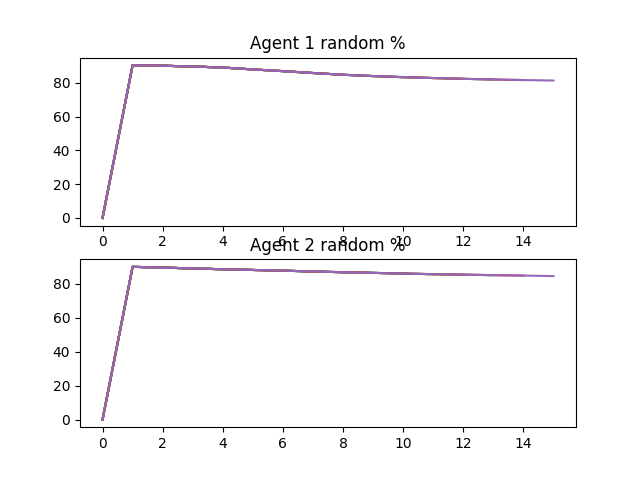

KeyboardInterrupt: 

In [59]:
train_notif.show()

agent1 = bingo_agent(state_size,action_size,1.0,0.9999,1000,0.9,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
agent2 = bingo_agent(state_size,action_size,1.0,0.9999,1000,0.9,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
train(agent1,agent2)

# agent1 = bingo_agent(state_size,action_size,1.0,0.999,50,0.9,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# agent2 = bingo_agent(state_size,action_size,1.0,0.999,50,0.5,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# train(agent1,agent2)

# agent1 = bingo_agent(state_size,action_size,1.0,0.999,50,0.9,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# agent2 = bingo_agent(state_size,action_size,1.0,0.999,50,0.7,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# train(agent1,agent2)

# agent1 = bingo_agent(state_size,action_size,1.0,0.999,50,0.9,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# agent2 = bingo_agent(state_size,action_size,1.0,0.999,50,0.3,0.00001,10,15,'sigmoid','sigmoid','adam','mse')
# train(agent1,agent2)

train_comp_notif.show()

In [ ]:
class bingo_player:
    def __init__(self):
        self.grid = np.random.choice(range(1,26),25,replace = False)
        
    def create_grid(self):
        self.grid = np.random.choice(range(1,26),25,replace = False)   
    
    def show_grid(self,state):
        temp_grid = np.copy(self.grid)
        temp_grid[[i for i in range(25) if state[0,i] == 1]] = 0
        sq_grid = np.reshape(temp_grid,[5,5])
        print (sq_grid)
        
    def perform_move(self,state,action):
        state[0,action] = 1
        lines = self.find_done(state)
        if (lines >= 5):
            done = True
        else:
            done = False
        reward = lines*5
        value = self.grid[action]
        return state,reward,done,value
    
    def find_done(self,state):
        lines = 0
        
        for i in range(5):
            line = True
            for j in range(5):
                if (state[0,i*5 + j] != 1):
                    line = False
            if (line):
                lines += 1
                
        for i in range(5):
            line = True
            for j in range(5):
                if (state[0,i + j*5] != 1):
                    line = False
            if (line):
                lines += 1
        
        line = True
        for i in range(5):
            if (state[0,i*6] != 1): 
                line = False
        if (line):
            lines += 1
        
        line = True
        for i in range(5):
            if (state[0,4 + i*4] != 1):
                line = False
        if (line):
            lines += 1
        if lines > 5:
            lines = 5
        return lines
    
    def convert_action(self,value):
        return np.where (self.grid == value)[0][0]

## Below is Computer vs Human

In [ ]:
human = bingo_player()
state1 = np.zeros(25) - 1
state1 = np.reshape(state1, [1,state_size])
state3 = np.zeros(25) - 1
state3 = np.reshape(state3, [1,state_size])

agent2.create_grid()
human.create_grid()

steps = 0

done1 = False
done3 = False

agent2.change_epsilon(0.0,0)

print ('Player 1 :')
agent2.show_grid(state1)
print ('Human :')
human.show_grid(state3)

while done1 == False and done3 == False:
    steps += 1
    action1,r_used = agent2.chooseAction(state1)
    state1,reward1,done1,value = agent2.perform_move(state1,action1)
    print ("Computer choice : " , value)
    action3 = human.convert_action(value)
    state3,reward3,done3,value = human.perform_move(state3,action3)
    
    if r_used:
        print('Random Used')

    if (done1 == True or done3 == True):
        break

    print ('Player 1 :')
    agent2.show_grid(state1)
    print ('Human :')
    human.show_grid(state3)
    value = input("Your choice : ")
    value = int (value)

    action3 = human.convert_action(value)
    state3,reward3,done3,_ = human.perform_move(state3,action3)
    action1 = agent2.convert_action(value)
    state1,reward1,done1,value = agent2.perform_move(state1,action1)

print ('Player 1 :')
agent2.show_grid(state1)
print ('Human :')
human.show_grid(state3)          

print("e: {:.2}, Steps: {}, Winner: Player 1 : {}, Human : {}"
      .format(agent2.Epsilon,steps,done1,done3))

In [ ]:
agent1.save("Bingo-P1.h5")
agent2.save("Bingo-P2.h5")

# Below is code snippet testing

In [ ]:
x = np.array([1])

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.title.set_text('First Plot')
ax2.title.set_text('Second Plot')
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(0,100):
    x = np.append(x,i%4)
    ax1.plot(x)
    ax2.plot(x%8)
    fig.canvas.draw()

In [42]:
x = np.empty([1,2])
x = np.vstack ((x,[30,40]))
x = np.delete(x,0,0)
print (x)

[[30. 40.]]
